In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn import preprocessing

import torch
from torch.nn import ModuleList, ModuleDict
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric_temporal.nn.hetero import HeteroGCLSTM
from torch_geometric_temporal.signal import temporal_signal_split

from airpollution_trf_graph_loader import AirpollutionDatasetLoader

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
n_layers= 2
_T= 12 # time horizon set to 12 hours
_city= 'madrid'
_include_trf= True # include or not traffic data as input

device_ =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_

device(type='cpu')

## Load dataset

In [3]:
loader= AirpollutionDatasetLoader(_city, include_trf=_include_trf)
dataset=loader.get_dataset(T=_T)
feature_dim= loader.get_feature_dim()
feature_dim

{'trf': 4, 'ap0': 2, 'ap1': 5, 'ap2': 2, 'ap3': 1}

In [4]:
column_names_trf= loader.get_column_names('ap0')
column_names_trf

['CO', 'SO2']

## Define GNN

In [5]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, in_channels_dict, out_channels, metadata, nlayers=2):
        super(HeteroGNN, self).__init__()      
        self.linears= ModuleDict({v:torch.nn.Linear(128,i) for v,i in in_channels_dict.items()})
        self.n_conv_layers=nlayers

        self.convs=ModuleList()
        self.convs.append(HeteroGCLSTM(in_channels_dict=in_channels_dict, out_channels=128, metadata=metadata))
        
        new_in_channel_dict={v:128 for v,i in in_channels_dict.items()}
        for l in range(0,self.n_conv_layers-1):
            self.convs.append(HeteroGCLSTM(in_channels_dict=new_in_channel_dict, out_channels=128, metadata=metadata))
        

    def forward(self, x_dict, edge_index_dict, h_dict_lst, c_dict_lst):
        new_h_lst=[]
        new_c_lst=[]
        x= x_dict
        for i in range(0,self.n_conv_layers):
            h, c= self.convs[i](x, edge_index_dict)
            x = {key: val.relu() for key, val in h.items()}
            new_h_lst.append(x)
            new_c_lst.append(c)
        
        h= {v: self.linears[v](emb_) for v,emb_ in x.items()}
        new_h_lst.append(h)
        return new_h_lst, new_c_lst

embedding_dim=1
model = HeteroGNN(in_channels_dict=feature_dim, out_channels= embedding_dim, metadata=dataset[0].metadata(), nlayers=n_layers)
model = model.to(device_)
    
train_dataset, test_dataset = temporal_signal_split(dataset,  train_ratio=0.90)

In [6]:
num_train_snapshots= sum(1 for _ in train_dataset)
num_testeval_snapshots= sum(1 for _ in test_dataset)
num_eval_snapshots = int(num_testeval_snapshots * 0.3)
num_test_snapshots= num_testeval_snapshots - num_eval_snapshots
print(num_train_snapshots, num_testeval_snapshots, num_test_snapshots, num_eval_snapshots)

426 48 34 14


## Train GNN

In [7]:
#Training parameters
n_epochs=600
batch_size= 24 * 1 #hours (1-day batch)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

def calculate_loss(y_hat_dict, y_dict):
    loss_= 0

    for p in y_hat_dict.keys():
        if p != 'trf':
            y_hat= y_hat_dict[p]
            y_hat= torch.nan_to_num(y_hat)
            particle_loss = torch.mean((y_hat-y_dict[p])**2) #MSE
            loss_ += particle_loss
    return loss_

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=5, min_delta=0.01)

model.train()

loss_epochs=[]
for epoch in tqdm(range(n_epochs), desc='Training epochs...'):
    
    batch_loss = 0
    counter=1    
    
    train_epoch_cost =0
    eval_epoch_cost= 0
    h_lst=[None for i in range(0,n_layers)]
    c_lst=[None for i in range(0,n_layers)]
        
    #train
    for time, train_snapshot in tqdm(enumerate(train_dataset), desc='Train snapshots...', leave=False):

        h_lst, c_lst = model(train_snapshot.x_dict, train_snapshot.edge_index_dict, h_lst, c_lst)

        h_dict= h_lst[-1]

        snap_train_loss= calculate_loss(h_dict, train_snapshot.y_dict)
        
        train_epoch_cost = train_epoch_cost + snap_train_loss  
        batch_loss = batch_loss + snap_train_loss
        
        if counter == batch_size:
            batch_loss = batch_loss / batch_size
            batch_loss.backward(retain_graph=True)
            opt.step()
            opt.zero_grad()
            counter=1
            batch_loss= 0
            
            h_lst=[None for i in range(0,n_layers)]
            c_lst=[None for i in range(0,n_layers)]
            
        else:
            counter += 1
            
    train_epoch_cost = train_epoch_cost / (time+1)
    
    # validation 
    with torch.no_grad(): 
        eval_h_lst=[None for i in range(0,n_layers)]
        eval_c_lst=[None for i in range(0,n_layers)]
        for time, test_snapshot in tqdm(enumerate(test_dataset), desc='Test snapshots...', leave=False):
            if time < num_test_snapshots:
                eval_h_lst, eval_c_lst = model(test_snapshot.x_dict, test_snapshot.edge_index_dict, eval_h_lst, eval_c_lst) 
                snap_eval_loss= calculate_loss(eval_h_lst[-1], test_snapshot.y_dict)
                eval_epoch_cost = eval_epoch_cost + snap_eval_loss
            
    eval_epoch_cost = eval_epoch_cost / (time+1)
   
    if early_stopper.early_stop(eval_epoch_cost):             
        print(f'EARLY STOP  AT epoch {epoch} - MSE (train): {train_epoch_cost}  - MSE (test): {eval_epoch_cost}')
        break
    print(f'Epoch {epoch} - MSE (train): {train_epoch_cost}  - MSE (test): {eval_epoch_cost}')
    loss_epochs.append((train_epoch_cost.item(), eval_epoch_cost.item()))
    

Training epochs...:   0%|          | 0/3 [00:00<?, ?it/s]

Train snapshots...: 0it [00:00, ?it/s]

Test snapshots...: 0it [00:00, ?it/s]

Epoch 0 - MSE (train): 5140.9970703125  - MSE (test): 2722.503173828125


Train snapshots...: 0it [00:00, ?it/s]

Test snapshots...: 0it [00:00, ?it/s]

Epoch 1 - MSE (train): 5060.00927734375  - MSE (test): 2649.971923828125


Train snapshots...: 0it [00:00, ?it/s]

Test snapshots...: 0it [00:00, ?it/s]

Epoch 2 - MSE (train): 4885.90185546875  - MSE (test): 2506.724365234375


At this point the model has been trained. Let's compute the validation results

In [8]:
loss_epochs_df= pd.DataFrame(loss_epochs, columns='train test'.split())
loss_epochs_df.head()

,train,test
0,5140.997070,2722.503174
1,5060.009277,2649.971924
2,4885.901855,2506.724365


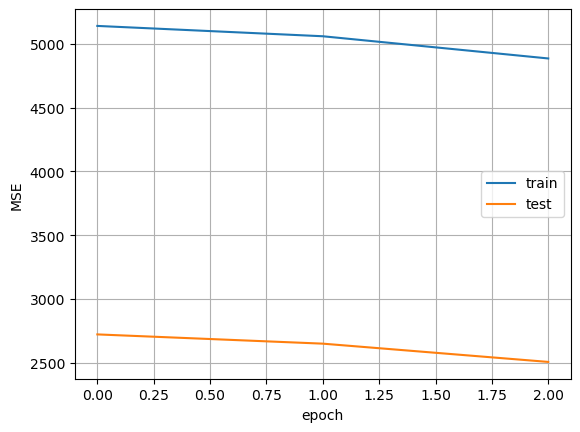

In [9]:
loss_epochs_df.plot(grid=True, xlabel='epoch', ylabel='MSE');
if not os.path.exists(os.path.join('figs')):
    os.makedirs(os.path.join('figs'))
if _include_trf:
    plt.savefig(os.path.join('figs',f'mse_loss_evol_{_city}_{_T}_trf.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join('figs',f'mse_loss_evol_{_city}_{_T}_no_trf.png'), bbox_inches='tight')

## Get validation results

In [10]:
# validation 
with torch.no_grad(): 
    eval_h_lst=[None for i in range(0,n_layers)]
    eval_c_lst=[None for i in range(0,n_layers)]
    y_hat_dict={}
    y_true_dict={}
    for time, test_snapshot in tqdm(enumerate(test_dataset), desc='Eval snapshots...', leave=False):
        if time >= num_test_snapshots:
            eval_h_lst, eval_c_lst = model(test_snapshot.x_dict, test_snapshot.edge_index_dict, eval_h_lst, eval_c_lst) 
             #print(eval_h_lst[-1]['trf'])

            for k in test_snapshot.y_dict.keys():
                v= y_hat_dict.get(k,[])
                v.append(eval_h_lst[-1][k])
                y_hat_dict[k]= v
                
                v= y_true_dict.get(k,[])
                v.append(test_snapshot.x_dict[k])
                y_true_dict[k]= v

    y_hat_df={}
    for k,v in y_hat_dict.items():
        _cols= loader.get_column_names(k)
        y_hat_df[k]= pd.DataFrame(torch.vstack(v), columns=_cols)

    y_true_df={}
    for k,v in y_true_dict.items():
        _cols= loader.get_column_names(k)
        y_true_df[k]= pd.DataFrame(torch.vstack(v), columns=_cols)
    
    if not os.path.exists(os.path.join('results')):
        os.makedirs(os.path.join('results'))

    for k, _df in y_hat_df.items():
        if _include_trf:
            _df.to_csv(os.path.join('results',f'y_hat_{_city}_{_T}_{k}_trf.csv'))
        else:
            _df.to_csv(os.path.join('results',f'y_hat_{_city}_{_T}_{k}_no_trf.csv'))
    for k, _df in y_true_df.items():
        if _include_trf:
            _df.to_csv(os.path.join('results',f'y_true_{_city}_{_T}_{k}_trf.csv'))    
        else:
            _df.to_csv(os.path.join('results',f'y_true_{_city}_{_T}_{k}_no_trf.csv'))    

Eval snapshots...: 0it [00:00, ?it/s]

In [11]:
print("That's all folks!")

That's all folks!
